In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
import os

In [2]:
print(tf.__version__)

2.3.0


In [3]:
data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
print(len(tf.io.gfile.glob(data_dir + "/*/*")))

5216


In [4]:
# I will be using a 80:20 train:validation set split

IMG_COUNT = len(tf.io.gfile.glob(data_dir + "/*/*"))
VAL_IMG_COUNT = int(0.2 * IMG_COUNT)
TRAIN_IMG_COUNT = int(IMG_COUNT - VAL_IMG_COUNT)
print("Total image count:", IMG_COUNT)
print("Training image count:", TRAIN_IMG_COUNT)
print("Validation image count:", VAL_IMG_COUNT)

Total image count: 5216
Training image count: 4173
Validation image count: 1043


Here is one training image:


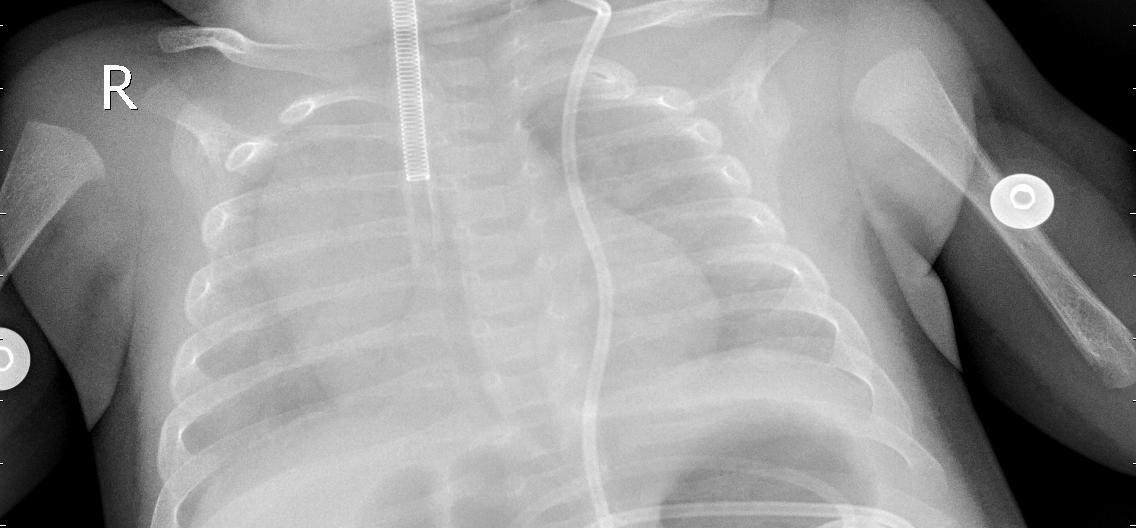

In [5]:
train_images = list(tf.io.gfile.glob(data_dir + "/*/*"))
print("Here is one training image:")
PIL.Image.open(train_images[0])

In [6]:
batch_size = 32
img_height = 180
img_width = 180
IMAGE_SIZE = (img_height, img_width)

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 0,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.


In [8]:
COUNT_NORMAL = 0
COUNT_PNEUMONIA = 0

for image, label in train_ds:
    temp = label.numpy()
    for i in temp:
        if i == 1:
            COUNT_PNEUMONIA += 1
        else:
            COUNT_NORMAL += 1

In [11]:
print(COUNT_PNEUMONIA)
print(COUNT_NORMAL)
print(COUNT_PNEUMONIA + COUNT_NORMAL)

3093
1080
4173


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 0,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 5216 files belonging to 2 classes.
Using 1043 files for validation.


In [13]:
VAL_COUNT_NORMAL = 0
VAL_COUNT_PNEUMONIA = 0

for image, label in val_ds:
    temp = label.numpy()
    for i in temp:
        if i == 1:
            VAL_COUNT_PNEUMONIA += 1
        else:
            VAL_COUNT_NORMAL += 1

In [14]:
print(VAL_COUNT_PNEUMONIA)
print(VAL_COUNT_NORMAL)
print(VAL_COUNT_PNEUMONIA + VAL_COUNT_NORMAL)

782
261
1043


In [15]:
class_names = train_ds.class_names
print("The class names are: ", class_names)

The class names are:  ['NORMAL', 'PNEUMONIA']


5x5 grid of images:


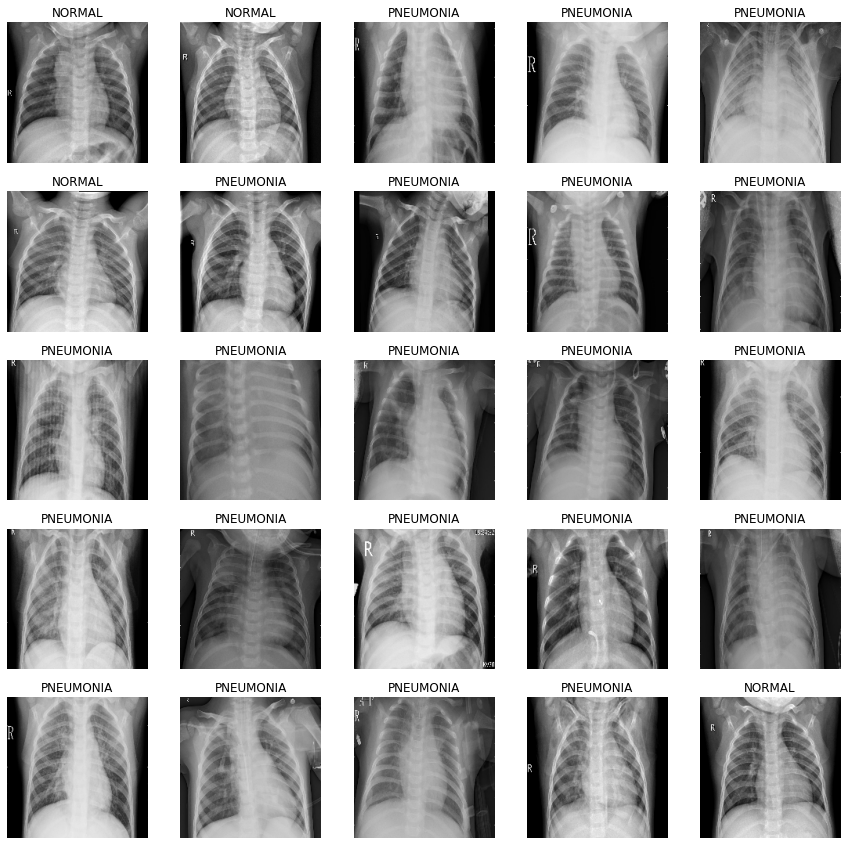

In [16]:
print("5x5 grid of images:")
plt.figure(figsize=(15,15))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [18]:
# To improve performance of the model while training:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    return block

In [20]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [38]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.4),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [22]:
# Class weights to correct for the data imbalance

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.93
Weight for class 1: 0.67


In [23]:
# Callback functions to improve model's performance

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [39]:
model = build_model()

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)

In [40]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_9 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_10 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_5 (Dropout)          (None, 11, 11, 128)     

In [41]:
EPOCHS = 10
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/10
131/131 [==============================] - 13s 103ms/step - loss: 0.3894 - accuracy: 0.8138 - precision: 0.9386 - recall: 0.8012 - val_loss: 0.5869 - val_accuracy: 0.7248 - val_precision: 0.9769 - val_recall: 0.6483
Epoch 2/10
131/131 [==============================] - 13s 99ms/step - loss: 0.2185 - accuracy: 0.9099 - precision: 0.9719 - recall: 0.9046 - val_loss: 8.5393 - val_accuracy: 0.2541 - val_precision: 1.0000 - val_recall: 0.0051
Epoch 3/10
131/131 [==============================] - 13s 101ms/step - loss: 0.1819 - accuracy: 0.9274 - precision: 0.9751 - recall: 0.9256 - val_loss: 0.2151 - val_accuracy: 0.8993 - val_precision: 0.9942 - val_recall: 0.8708
Epoch 4/10
131/131 [==============================] - 13s 98ms/step - loss: 0.1499 - accuracy: 0.9413 - precision: 0.9847 - recall: 0.9353 - val_loss: 0.1288 - val_accuracy: 0.9482 - val_precision: 0.9906 - val_recall: 0.9399
Epoch 5/10
131/131 [==============================] - 13s 98ms/step - loss: 0.1350 - accuracy:

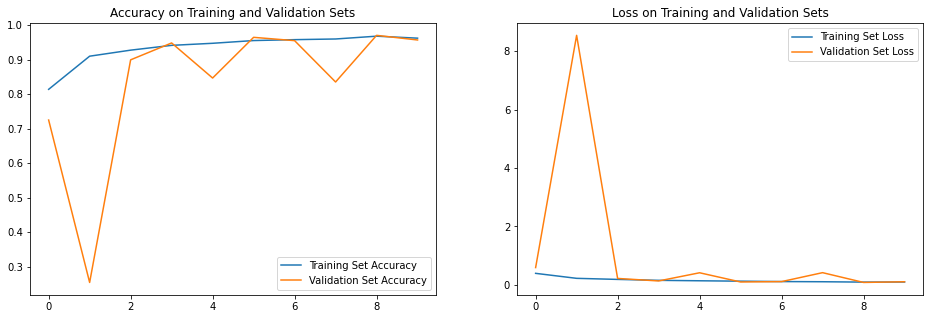

In [42]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy, label = "Training Set Accuracy")
plt.plot(epochs_range, val_accuracy, label = "Validation Set Accuracy")
plt.legend()
plt.title("Accuracy on Training and Validation Sets")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label = "Training Set Loss")
plt.plot(epochs_range, val_loss, label = "Validation Set Loss")
plt.legend()
plt.title("Loss on Training and Validation Sets")

plt.show()

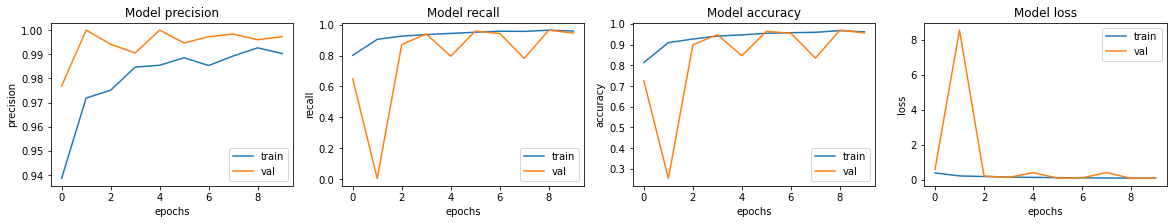

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [44]:
model.evaluate(val_ds)

33/33 [==============================] - 0s 12ms/step - loss: 0.1015 - accuracy: 0.9569 - precision: 0.9973 - recall: 0.9450


[0.10154076665639877,
 0.9568552374839783,
 0.997300922870636,
 0.9450128078460693]

In [45]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "/kaggle/input/chest-xray-pneumonia/chest_xray/test",
    seed = 0,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 624 files belonging to 2 classes.


In [46]:
loss, acc, prec, rec = model.evaluate(test_ds)

20/20 [==============================] - 2s 95ms/step - loss: 0.5300 - accuracy: 0.8494 - precision: 0.8190 - recall: 0.9744


### Test Accuracy is ~ 85%, which is quite good. 